In [3]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x28fe76755d0>)

In [ ]:
from ochumanApi.ochuman import OCHuman
import cv2, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

import ochumanApi.vis as vistool
from ochumanApi.ochuman import Poly2Mask
import cv2
from tqdm.notebook import tqdm
import numpy as np

ImportError: Building module ochumanApi._mask failed: ["distutils.errors.CompileError: command 'C:\\\\Program Files\\\\Microsoft Visual Studio\\\\2022\\\\Preview\\\\VC\\\\Tools\\\\MSVC\\\\14.36.32522\\\\bin\\\\HostX86\\\\x64\\\\cl.exe' failed with exit code 2\n"]

In [2]:
ochuman = OCHuman(AnnoFile='ochuman.json', Filter='segm')
image_ids = ochuman.getImgIds()
print('Total images: %d'%len(image_ids))

Total images: 4731


In [3]:
def get_segmentation(data):
    img = cv2.imread(os.path.join(IMAGE_DIR, data['file_name']))
    height, width = data['height'], data['width']
    colors = [
        [255, 0, 0],
        [255, 255, 0],
        [0, 255, 0],
        [0, 255, 255],
        [0, 0, 255],
        [255, 0, 255]
    ]

    for i, anno in enumerate(data['annotations']):
        bbox = anno['bbox']
        kpt = anno['keypoints']
        segm = anno['segms']
        max_iou = anno['max_iou']

        if segm is not None:
            mask = Poly2Mask(segm)
            img = vistool.draw_mask(img, mask, thickness=3, color = colors[i%len(colors)])
    return img

In [4]:
def new_mask(real_img, m_img):
    real_img = real_img.reshape(1, -1)[0]
    m_img = m_img.reshape(1, -1)[0]
    new = []

    for i, j in zip(real_img, m_img):
        if i != j:
            new.append(255)
        else:
            new.append(0)
    
    new_np = np.array(new)
    new_np = new_np.reshape(512, 512, 3)
    return new_np

In [5]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMAGE_DIR = 'images/images/'

In [6]:
def generator_image(batch_size= 1, ind = 0):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            data = ochuman.loadImgs(imgIds= [image_ids[ind]])[0]

            file_name = data['file_name']

            img = cv2.imread(IMAGE_DIR + file_name)

            y = get_segmentation(data)

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

            y = cv2.resize(y, (IMG_WIDTH, IMG_HEIGHT))

            new = new_mask(img, y)

            img = img / 255.
            y = new / 255.
            x_batch.append(img)
            y_batch.append(y)

        x_batch = np.array(x_batch)
        y_batch = {'seg': np.array(y_batch)}

        yield x_batch, y_batch            

In [7]:
X = []
Y = []
for x, y in generator_image(2, 1):
    X = x
    Y = y
    break

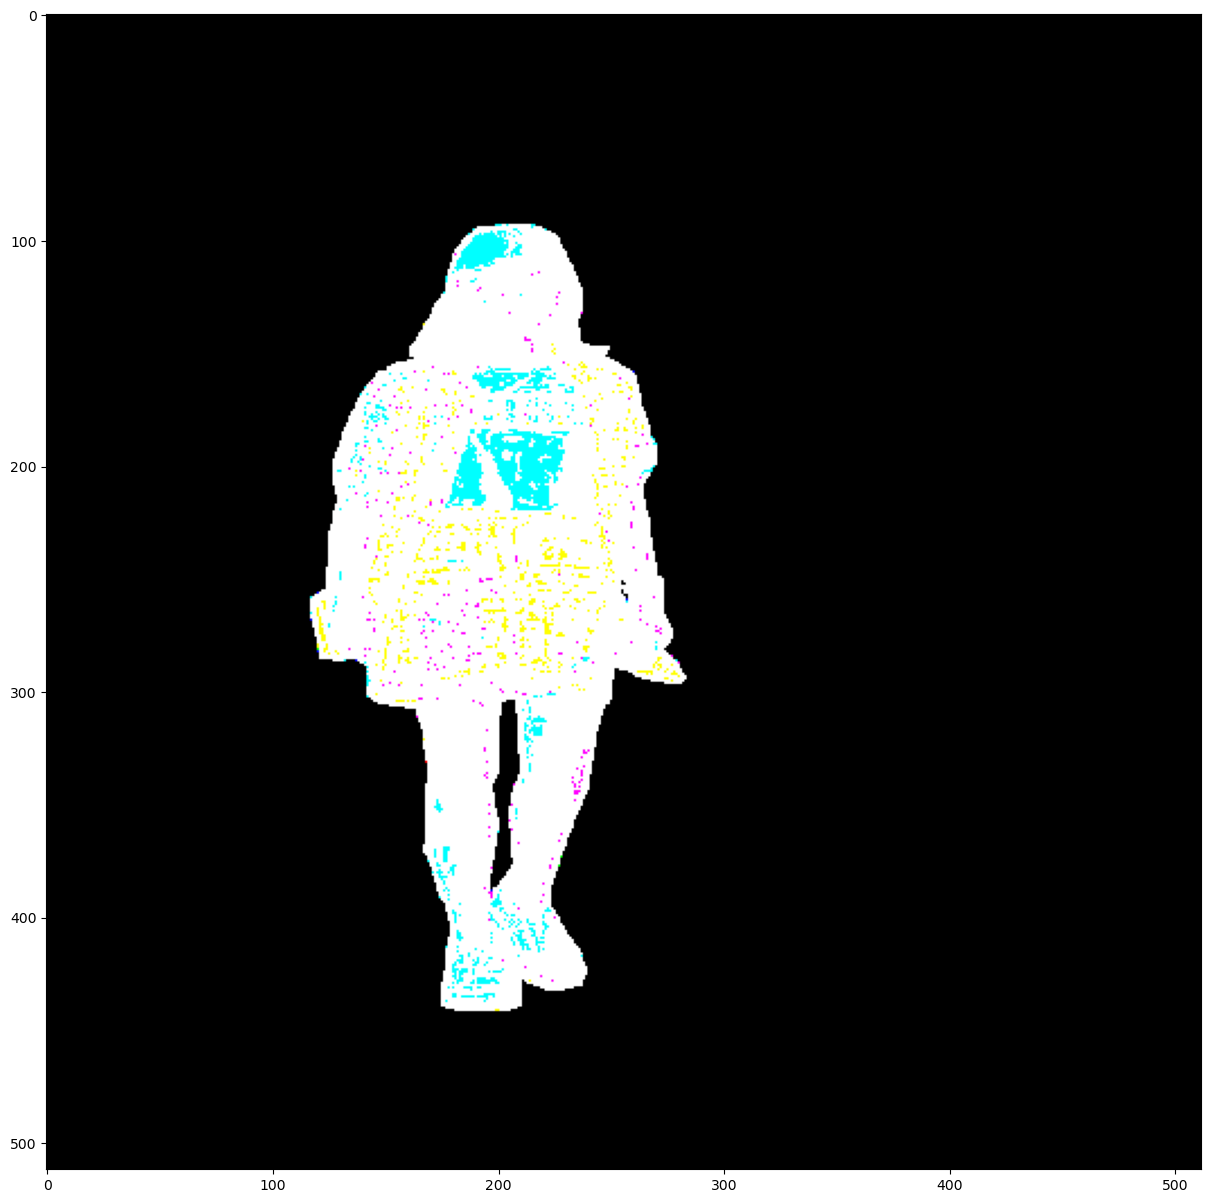

In [8]:
plt.imshow(X[0])
plt.imshow(Y['seg'][0])

In [9]:
for i in tqdm(range(4731)):
    X = []
    Y = []
    for x, y in generator_image(1, i):
        X = x
        Y = y
        break
    base_dir_custom = "custom_dataset_human_black_background/"
    try:
        os.makedirs(f'{base_dir_custom}')
    except:
        pass

    try:
        os.makedirs(f'{base_dir_custom}features/')
    except:
        pass

    try:
        os.makedirs(f'{base_dir_custom}labels/')
    except:
        pass

    x_name = f"{base_dir_custom}features/{i}_x.jpg"
    y_name = f"{base_dir_custom}labels/{i}_y.jpg"
    cv2.imwrite(x_name, x[0] * 255.)
    cv2.imwrite(y_name, y['seg'][0] * 255.)

  0%|          | 0/4731 [00:00<?, ?it/s]